In [1]:
from ast import literal_eval
import os

import logging
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import pandas as pd
import torch

from src.object_detector.custom_image_dataset_object_detector import CustomImageDataset

In [2]:
# define configurations for training run
RUN = 0
PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.1
PERCENTAGE_OF_VAL_SET_TO_USE = 1
BATCH_SIZE = 16
NUM_WORKERS = 12
EPOCHS = 30
LR = 1e-2
EVALUATE_EVERY_K_STEPS = 3500  # how often to evaluate the model on the validation set and log metrics to tensorboard (additionally, model will always be evaluated at end of epoch)
PATIENCE = 10  # number of evaluations to wait before early stopping
PATIENCE_LR_SCHEDULER = 3  # number of evaluations to wait for val loss to reduce before lr is reduced by 1e-1


In [3]:
def get_datasets_as_dfs():
    path_dataset_object_detector = "/u/home/tanida/datasets/dataset-for-full-model-50"

    usecols = ["mimic_image_file_path", "bbox_coordinates", "bbox_labels"]

    # since bbox_coordinates and labels are stored as strings in the csv_file, we have to apply 
    # the literal_eval func to convert them to python lists
    converters = {"bbox_coordinates": literal_eval, "bbox_labels": literal_eval}

    datasets_as_dfs = {dataset: os.path.join(path_dataset_object_detector, f"{dataset}-50") + ".csv" for dataset in ["train", "valid", "test"]}
    datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, converters=converters) for dataset, csv_file_path in datasets_as_dfs.items()}

    total_num_samples_train = len(datasets_as_dfs["train"])
    total_num_samples_val = len(datasets_as_dfs["valid"])

    # compute new number of samples for both train and val
    new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)
    new_num_samples_val = int(PERCENTAGE_OF_VAL_SET_TO_USE * total_num_samples_val)

    # limit the datasets to those new numbers
    datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]
    datasets_as_dfs["valid"] = datasets_as_dfs["valid"][:new_num_samples_val]

    return datasets_as_dfs


In [4]:
datasets_as_dfs = get_datasets_as_dfs()

In [5]:
def get_transforms(dataset: str):
    # see compute_mean_std_dataset.py in src/dataset_bounding_boxes
    mean = 0.471
    std = 0.302

    # note: transforms are applied to the already resized (to 224x224) and padded images 
    # (see __getitem__ method of custom dataset class)!

    # use albumentations for Compose and transforms
    train_transforms = A.Compose([
        # optionally add augmentation transforms here (but bboxes also have to be transformed in this case!)
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    # don't apply data augmentations to val and test set
    val_test_transforms = A.Compose(
        [
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ]
    )

    if dataset == "train":
        return train_transforms
    else:
        return val_test_transforms



In [6]:
train_transforms = get_transforms("train")
val_transforms = get_transforms("val")

In [7]:
train_dataset = CustomImageDataset(datasets_as_dfs["train"], train_transforms)
val_dataset = CustomImageDataset(datasets_as_dfs["valid"], val_transforms)

In [8]:
import pandas as pd
import numpy as np
import os, re 
import time
from numpy import genfromtxt
import json
import cv2
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)
%matplotlib inline

3.5.2


In [8]:
from src.dataset_bounding_boxes.constants import ANATOMICAL_REGIONS

In [22]:
def checkCoord(x,dim):
    if x < 0:
        x = 0
    if x > dim:
        x = dim
    return x

# Draw bbox on image -- has the option to save image with not margin for annotation
def drawBbox(image, x1, y1, x2, y2, bbox_name=None, phrases=None, plot=True,exportfilepath=None):
    image = image.copy()
    stroke = 10
    w,h = image.shape
    x1 = checkCoord(int(x1), w)
    y1 = checkCoord(int(y1), h)
    x2 = checkCoord(int(x2), w)
    y2 = checkCoord(int(y2), h)
    image[y1:y1 + stroke, x1:x2] = 3
    image[y2:y2 + stroke, x1:x2] = 3
    image[y1:y2, x1:x1 + stroke] = 3
    image[y1:y2, x2:x2 + stroke] = 3
    
    if plot:
        dpi = 3000
        # What size does the figure need to be in inches to fit the image?
        height, width = image.shape
        figsize = width / float(dpi), height / float(dpi)
        figsize = width / 30., height / 30.
        # To make a figure without the frame :
#         fig = plt.figure(frameon=False) # gives a bug in the plt 3.1.0 + this jupyter notebook env for some reason
        fig = plt.figure()
        fig.set_size_inches(figsize)
        # To make the content fill the whole figure
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        
        if bbox_name:
            ax.set_title(bbox_name)
            
        if phrases:
            fig.text(.5, .05, phrases, ha='center')

        # Then draw your image on it :
        ax.imshow(image, cmap='gray', aspect='auto', interpolation='nearest')

        # Ensure we're displaying with square pixels and the right extent.
        # This is optional if you haven't called `plot` or anything else that might
        # change the limits/aspect.
        ax.set(xlim=[-0.5, width - 0.5], ylim=[height - 0.5, -0.5], aspect='auto')
        
    if exportfilepath!=None:
        fig.savefig(exportfilepath, dpi=dpi, transparent=True)
        
#     if plot:
#         plt.figure(figsize=(10, 10))
#         plt.imshow(image, cmap='gray')
#         # plt.close() #or won't show up in notebook if run
#     if exportfilepath!=None:
#         fig.savefig(exportfilepath, dpi=80, transparent=True)
    return image


# visualize an object given image_id and name
def plot_object(image, bboxes, labels, index):
    bbox = bboxes[index]
    class_label = labels[index]

    for region_name, id in ANATOMICAL_REGIONS.items():
        if (class_label-1) == id:
            bbox_name = region_name

    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]

    drawBbox(image, x1, y1, x2, y2, bbox_name, None)

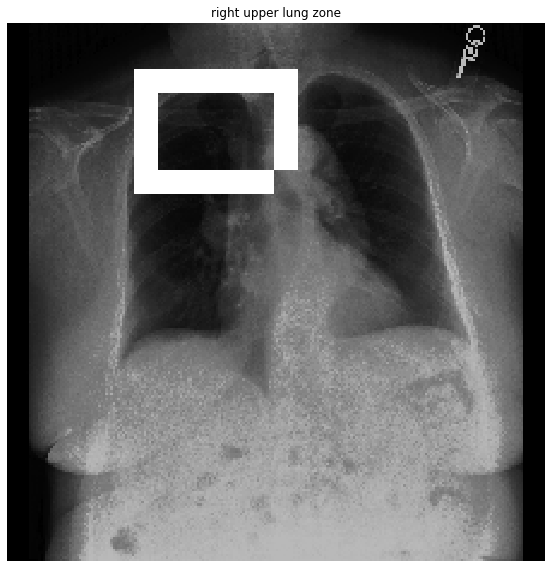

In [39]:
plot_object(single_image.squeeze().numpy(), bboxes, labels, 1)

In [9]:
from object_detector import ObjectDetector

In [10]:
model = ObjectDetector()
path_to_best_object_detector_weights = "/u/home/tanida/runs/object_detector/run_5/weights/last_epoch.pth"
model.load_state_dict(torch.load(path_to_best_object_detector_weights))

<All keys matched successfully>

In [11]:
model.eval()

ObjectDetector(
  (backbone): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [12]:
first_image = train_dataset[0]["image"]
second_image = train_dataset[1]["image"]
third_image = train_dataset[2]["image"]
fourth_image = train_dataset[3]["image"]

In [15]:
batch = torch.stack([first_image, second_image, third_image, fourth_image], dim=0)
pred = model(batch)

In [16]:
_, detections = pred
first_pred = detections[0]
len(first_pred["boxes"])

73

In [17]:
first_pred

{'boxes': tensor([[3.3981e+01, 1.0255e+02, 1.8761e+02, 2.2116e+02],
         [9.5557e+01, 2.1286e+01, 1.9532e+02, 1.5333e+02],
         [3.3242e+01, 1.5846e+01, 9.9875e+01, 1.5332e+02],
         [8.9586e+01, 3.4150e+01, 1.6453e+02, 1.3827e+02],
         [9.4690e+01, 3.5509e+01, 1.4225e+02, 8.5271e+01],
         [9.7362e+01, 7.8784e-01, 1.2088e+02, 9.0019e+01],
         [3.4993e+01, 1.0335e+02, 1.0124e+02, 2.1935e+02],
         [8.9783e+01, 8.6144e+01, 1.6345e+02, 1.3895e+02],
         [1.0191e+02, 1.0471e+02, 1.8980e+02, 2.2064e+02],
         [6.1397e+01, 1.5717e+01, 1.1445e+02, 3.6113e+01],
         [2.3251e+01, 1.2517e+02, 4.1919e+01, 1.4461e+02],
         [9.9686e+01, 0.0000e+00, 1.3285e+02, 2.1526e+02],
         [3.9360e+01, 9.5060e+01, 1.0188e+02, 1.5160e+02],
         [1.9710e+01, 3.2651e+01, 5.3314e+01, 3.9391e+01],
         [1.1283e+02, 8.4562e+01, 1.6530e+02, 1.3681e+02],
         [1.0863e+02, 5.9678e+01, 1.4065e+02, 1.2174e+02],
         [4.4632e+01, 6.0058e+01, 1.0012e+02, 9